# Import the necessary modules

In [1]:
%matplotlib inline
import sys
import os.path
import pandas as pd
import seaborn as sns; sns.set(); sns.set_style("ticks", {'axes.spines.right': False,
                                                          'axes.spines.top': False})
import matplotlib.pyplot as plt
font = {'size'   : 10}
plt.rc('font', **font)
import numpy as np
from scipy import stats
from scipy import optimize

# make sure we find the right python module
sys.path.append(os.path.join('..','src'))

import covid_inference; import covid_models

# Defining models as classes

In this code, models used to perform inference on data are defined as classes. They take the data as input, and contain methods which calculate the log likelihood, log likelihood gradient, and log likelihood hessian. The table below indicates which methods are needed to perform each of the algorithms.

|                         | Random Walk | MALA     | smMALA   |
| :--------               | :---------: | :------: | :------: |
| log_likelihood          | &#10003;    | &#10003; | &#10003; |
| log_likelihood_gradient |             | &#10003; | &#10003; |
| log_likelihood_hessian  |             |          | &#10003; |

<div class="alert alert-block alert-info">
    <b>Tip:</b> Look in <b>/src/covid_models.py</b> for an idea of how to construct your own model classes
</div>

# Negative Binomial Regression

We will test out our algorithms on some synthetic negative binomial data.

#### Generate and visualise synthetic data

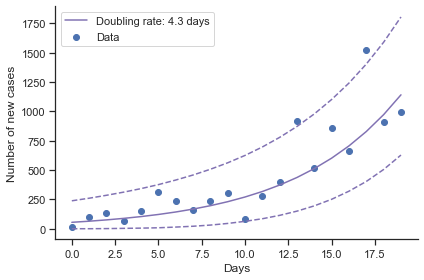

In [2]:
# generate data
number_of_days = 20
regression_coefficients = np.array([4,0.16,80])
days = np.arange(number_of_days)
mu_data = np.exp(regression_coefficients[0])*np.exp(regression_coefficients[1]*days)
od_data = regression_coefficients[2]*np.ones(number_of_days)
r_data=mu_data/(od_data-1)
p_data = 1/od_data
data = stats.nbinom.rvs(r_data,p_data)

doubling_time_data = np.log(2.0)/regression_coefficients[1]

# visualise with confidence intervals
plt.scatter(days,data,label='Data')
plt.plot(days,mu_data,'-',c='m',label='Doubling rate: {:.1f} days'.format(doubling_time_data))
plt.plot(days,stats.nbinom.ppf(0.025,r_data,p_data),linestyle='--',c='m')
plt.plot(days,stats.nbinom.ppf(0.975,r_data,p_data),linestyle='--',c='m')
plt.xlabel('Days')
plt.ylabel('Number of new cases')
plt.legend()
plt.tight_layout()

# Use the negative binomial model class to perform Bayesian inference 

We can do a similar type of visualisation as above, using uncertainty quantification from the Markov chains

# Random Walk Metropolis
First we take the data and minimise the negative log-likelihood for initialisation of our chain. Then we run the random walk algorithm twice. The first run gives us an idea of the correlation structure, which we use for the second run in order to sample as effectively as possible.

In [3]:
negative_binomial_test = covid_models.negative_binomial_data(data)
number_of_samples = 100000
step_size = 0.05
thinning_rate = 1

initial_position = optimize.minimize(negative_binomial_test.log_likelihood,
                                     np.array([4,0.2,100]),method='Nelder-Mead',args=(True)).x

print('Initial position:',initial_position)

# first run
print('\nFirst Run')
output = covid_inference.random_walk(negative_binomial_test,
                                     number_of_samples,
                                     initial_position,
                                     step_size,
                                     thinning_rate=thinning_rate)

# obtain correlation structure for proposal covariance matrix
proposal_covariance = np.cov(output.T)
step_size = 2.5

#second run
print('\nSecond Run')
output = covid_inference.random_walk(negative_binomial_test,
                                     number_of_samples,
                                     initial_position,
                                     step_size,
                                     proposal_covariance=proposal_covariance,
                                     thinning_rate=thinning_rate)

print('Coefficient 1 mean:',np.mean(output[:,0]))
print('Coefficient 2 mean:',np.mean(output[:,1]))
print('Coefficient 3 mean:',np.mean(output[:,2]))

Initial position: [ 4.42733488  0.14208605 69.80835411]

First Run
Progress:  10 %
Progress:  20 %
Progress:  30 %
Progress:  40 %
Progress:  50 %
Progress:  60 %
Progress:  70 %
Progress:  80 %
Progress:  90 %
Acceptance ratio: 0.14692

Second Run
Progress:  10 %
Progress:  20 %
Progress:  30 %
Progress:  40 %
Progress:  50 %
Progress:  60 %
Progress:  70 %
Progress:  80 %
Progress:  90 %
Acceptance ratio: 0.24819
Coefficient 1 mean: 4.474931695535981
Coefficient 2 mean: 0.13906179453997639
Coefficient 3 mean: 94.98437645120059


# Visualise output

#### Markov  chains

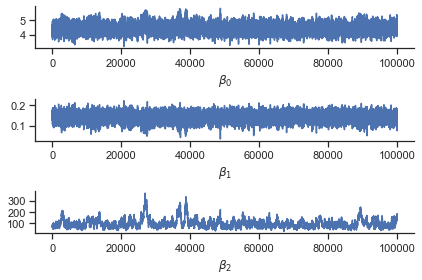

In [11]:
fig, ax = plt.subplots(3,1,figsize=(6,4))
for i in range(output.shape[1]):
    ax[i].plot(output[:,i])
    ax[i].set_xlabel('$\\beta_{}$'.format(i))
plt.tight_layout()
plt.show()

#### Pair Grid

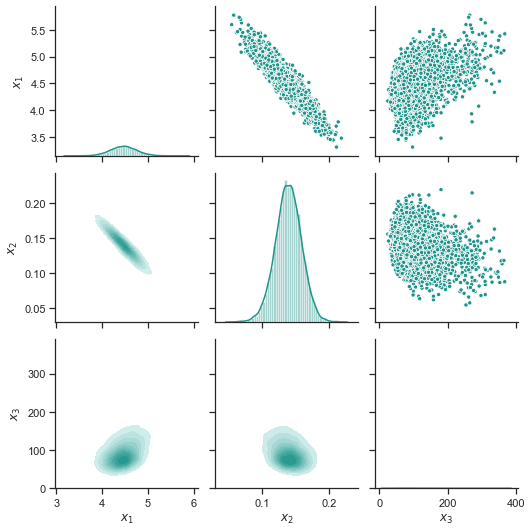

In [5]:
g = sns.PairGrid(pd.DataFrame(output[:-1:10],columns=['$x_1$','$x_2$','$x_3$']))
g = g.map_upper(sns.scatterplot,size=2,color='#20948B')
g = g.map_lower(sns.kdeplot,color="#20948B",shade=True,shade_lowest=False)
g = g.map_diag(sns.distplot,color='#20948B')
plt.tight_layout()

#### Time series

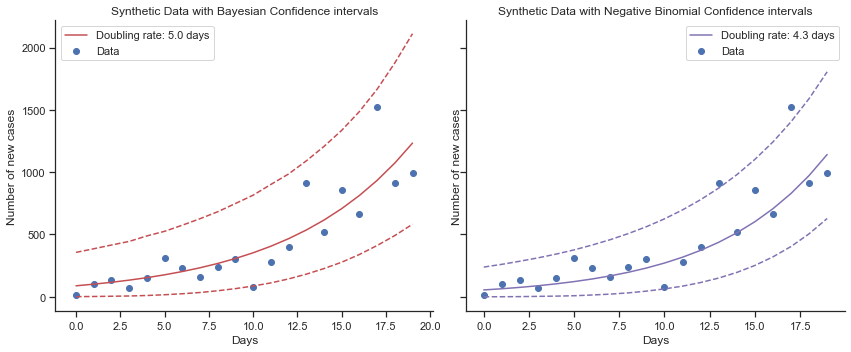

In [6]:
thinning_rate = 1
ys = np.zeros((number_of_days,number_of_samples//thinning_rate))

for day in range(number_of_days):
    mu = np.exp(output[::thinning_rate,0])*np.exp(output[::thinning_rate,1]*day)
    od = output[::thinning_rate,2]
    p = 1/od
    r = mu/(od-1)
    ys[day] = np.random.negative_binomial(r,p)
    
mu = np.exp(np.mean(output[:,0]))*np.exp(np.mean(output[:,1])*days)
lower_error = np.percentile(ys,2.5,axis=1)
upper_error = np.percentile(ys,97.5,axis=1)

doubling_time = np.log(2.0)/np.mean(output[:,1])

fig, ax = plt.subplots(1,2,figsize=(12,5),sharey='row')
ax[0].plot(days,mu,linestyle='-',c='r',
           label='Doubling rate: {:.1f} days'.format(doubling_time))
ax[0].plot(days,lower_error,linestyle='--',c='r')
ax[0].plot(days,upper_error,linestyle='--',c='r')
ax[0].scatter(days,data,label='Data')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Number of new cases')
ax[0].set_title('Synthetic Data with Bayesian Confidence intervals')
ax[0].legend()

ax[1].scatter(days,data,label='Data')
ax[1].plot(days,mu_data,'-',c='m',
           label='Doubling rate: {:.1f} days'.format(doubling_time_data))
ax[1].plot(days,stats.nbinom.ppf(0.025,r_data,p_data),linestyle='--',c='m')
ax[1].plot(days,stats.nbinom.ppf(0.975,r_data,p_data),linestyle='--',c='m')
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Number of new cases')
ax[1].set_title('Synthetic Data with Negative Binomial Confidence intervals')
ax[1].legend()

plt.tight_layout()

# Real world data
The next step is to test this approach on real world data, rather than synthetic data

In [ ]:
df = pd.read_csv(r'data/italy_data.csv')
data = df['Confirmed']